In [ ]:
import datetime
start_time = datetime.datetime.now().strftime("%d %b, %H:%M:%S")
start_time

dataset = 1  # 1: hardhat, 2: scratch

In [ ]:
#take a look at the kind of GPU we have
!nvidia-smi

Thu Jan 21 06:49:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# How to Train YOLOv5 on Custom Objects

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference



### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://ucd5150861f0b72b393669281023.previews.dropboxusercontent.com/p/thumb/AA-XyIcr8uqT6ZWpKsHJp_vv_zW-k012FwUIwyy3OJGF88VvLOpOzfB67EFFnEOKyXsKW3VG8qBENNkR4P2w1ZQd6SEBDfpBnYcLRw-9T_Fx2teCZpQTY33FHsPserUYfiZCyrfZpRRdgn7A4x34bhRu0_uwZvnx9q9Y804YL7DDX1MnD_omfZRuNDsetojhW3CwoQN6_srexqynYgQrzYKt4syhKF23FawIUP4-g1irhcH5Zh25GJNxVx-B0ZL9hB3VS-w9RA68lbvQvHOm_qvrQ0sXzwClHWMJNcricHssKyscqmnB8H_h2JWqJUgQk8DXeq7EeT6aHAoLsEwSEUhU0Q0B3IhLBY5_O0bee759pA/p.png?fv_content=true&size_mode=5)



#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone YOLOv5 and reset to a specific git checkpoint that has been verified working
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 68211f72c99915a15855f7b99bf5d93f5631330f

Cloning into 'yolov5'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4319 (delta 0), reused 1 (delta 0), pack-reused 4315
Receiving objects: 100% (4319/4319), 7.34 MiB | 4.97 MiB/s, done.
Resolving deltas: 100% (2931/2931), done.
/content/yolov5
HEAD is now at 68211f7 FROM nvcr.io/nvidia/pytorch:20.10-py3 (#1553)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 645kB 4.1MB/s 
Setup complete. Using torch 1.7.0+cu101 _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16130MB, multi_processor_count=80)


In [ ]:
# Export code snippet and paste here
from google_drive_downloader import GoogleDriveDownloader as gdd

%cd /content

if dataset == 1:
  drive_id = '1NuVjqnIgXo064rSA14ltxEhHgdnObBE0'  # Hardhat
else:
  drive_id = '1syp3Tym7LJnLynEUJ-qROotZfNYaK-Wo'  # Scratch

gdd.download_file_from_google_drive(file_id=drive_id,
                                    dest_path='./dataset.zip',
                                    unzip=True)

!rm dataset.zip

!mv data_yolo5/* .
!rm -r data_yolo5

/content
Unzipping...Done.


In [ ]:
# %mv /content/test/ /content/valid/

In [ ]:
# Instert missing line for test data

f = open("data.yaml", "r")
contents = f.readlines()
f.close()

contents.insert(2, 'test: ../test/images/\n')

f = open("data.yaml", "w")
contents = "".join(contents)
f.write(contents)
f.close()

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images/
val: ../valid/images/
test: ../test/images/

nc: 3

names: ['head', 'helmet', 'person']

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
# %cat /content/yolov5/models/yolov5s.yaml

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))


In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# temp fix for image_weights=opt.image_weights error, see: https://github.com/ultralytics/yolov5/issues/1550
%%writefile /content/yolov5/utils/train.py
import argparse
import logging
import math
import os
import random
import time
from pathlib import Path
from warnings import warn

import numpy as np
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import yaml
from torch.cuda import amp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import test  # import test.py to get mAP after each epoch
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.datasets import create_dataloader
from utils.general import labels_to_class_weights, increment_path, labels_to_image_weights, init_seeds, \
    fitness, strip_optimizer, get_latest_run, check_dataset, check_file, check_git_status, check_img_size, \
    print_mutation, set_logging
from utils.google_utils import attempt_download
from utils.loss import compute_loss
from utils.plots import plot_images, plot_labels, plot_results, plot_evolution
from utils.torch_utils import ModelEMA, select_device, intersect_dicts, torch_distributed_zero_first

logger = logging.getLogger(__name__)

try:
    import wandb
except ImportError:
    wandb = None
    logger.info("Install Weights & Biases for experiment logging via 'pip install wandb' (recommended)")


def train(hyp, opt, device, tb_writer=None, wandb=None):
    logger.info(f'Hyperparameters {hyp}')
    save_dir, epochs, batch_size, total_batch_size, weights, rank = \
        Path(opt.save_dir), opt.epochs, opt.batch_size, opt.total_batch_size, opt.weights, opt.global_rank

    # Directories
    wdir = save_dir / 'weights'
    wdir.mkdir(parents=True, exist_ok=True)  # make dir
    last = wdir / 'last.pt'
    best = wdir / 'best.pt'
    results_file = save_dir / 'results.txt'

    # Save run settings
    with open(save_dir / 'hyp.yaml', 'w') as f:
        yaml.dump(hyp, f, sort_keys=False)
    with open(save_dir / 'opt.yaml', 'w') as f:
        yaml.dump(vars(opt), f, sort_keys=False)

    # Configure
    plots = not opt.evolve  # create plots
    cuda = device.type != 'cpu'
    init_seeds(2 + rank)
    with open(opt.data) as f:
        data_dict = yaml.load(f, Loader=yaml.FullLoader)  # data dict
    with torch_distributed_zero_first(rank):
        check_dataset(data_dict)  # check
    train_path = data_dict['train']
    test_path = data_dict['val']
    nc, names = (1, ['item']) if opt.single_cls else (int(data_dict['nc']), data_dict['names'])  # number classes, names
    assert len(names) == nc, '%g names found for nc=%g dataset in %s' % (len(names), nc, opt.data)  # check

    # Model
    pretrained = weights.endswith('.pt')
    if pretrained:
        with torch_distributed_zero_first(rank):
            attempt_download(weights)  # download if not found locally
        ckpt = torch.load(weights, map_location=device)  # load checkpoint
        if hyp.get('anchors'):
            ckpt['model'].yaml['anchors'] = round(hyp['anchors'])  # force autoanchor
        model = Model(opt.cfg or ckpt['model'].yaml, ch=3, nc=nc).to(device)  # create
        exclude = ['anchor'] if opt.cfg or hyp.get('anchors') else []  # exclude keys
        state_dict = ckpt['model'].float().state_dict()  # to FP32
        state_dict = intersect_dicts(state_dict, model.state_dict(), exclude=exclude)  # intersect
        model.load_state_dict(state_dict, strict=False)  # load
        logger.info('Transferred %g/%g items from %s' % (len(state_dict), len(model.state_dict()), weights))  # report
    else:
        model = Model(opt.cfg, ch=3, nc=nc).to(device)  # create

    # Freeze
    freeze = []  # parameter names to freeze (full or partial)
    for k, v in model.named_parameters():
        v.requires_grad = True  # train all layers
        if any(x in k for x in freeze):
            print('freezing %s' % k)
            v.requires_grad = False

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / total_batch_size), 1)  # accumulate loss before optimizing
    hyp['weight_decay'] *= total_batch_size * accumulate / nbs  # scale weight_decay

    pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
    for k, v in model.named_modules():
        if hasattr(v, 'bias') and isinstance(v.bias, nn.Parameter):
            pg2.append(v.bias)  # biases
        if isinstance(v, nn.BatchNorm2d):
            pg0.append(v.weight)  # no decay
        elif hasattr(v, 'weight') and isinstance(v.weight, nn.Parameter):
            pg1.append(v.weight)  # apply decay

    if opt.adam:
        optimizer = optim.Adam(pg0, lr=hyp['lr0'], betas=(hyp['momentum'], 0.999))  # adjust beta1 to momentum
    else:
        optimizer = optim.SGD(pg0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)

    optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
    optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
    logger.info('Optimizer groups: %g .bias, %g conv.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
    del pg0, pg1, pg2

    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    # https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR
    lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - hyp['lrf']) + hyp['lrf']  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    # plot_lr_scheduler(optimizer, scheduler, epochs)

    # Logging
    if wandb and wandb.run is None:
        opt.hyp = hyp  # add hyperparameters
        wandb_run = wandb.init(config=opt, resume="allow",
                               project='YOLOv5' if opt.project == 'runs/train' else Path(opt.project).stem,
                               name=save_dir.stem,
                               id=ckpt.get('wandb_id') if 'ckpt' in locals() else None)

    # Resume
    start_epoch, best_fitness = 0, 0.0
    if pretrained:
        # Optimizer
        if ckpt['optimizer'] is not None:
            optimizer.load_state_dict(ckpt['optimizer'])
            best_fitness = ckpt['best_fitness']

        # Results
        if ckpt.get('training_results') is not None:
            with open(results_file, 'w') as file:
                file.write(ckpt['training_results'])  # write results.txt

        # Epochs
        start_epoch = ckpt['epoch'] + 1
        if opt.resume:
            assert start_epoch > 0, '%s training to %g epochs is finished, nothing to resume.' % (weights, epochs)
        if epochs < start_epoch:
            logger.info('%s has been trained for %g epochs. Fine-tuning for %g additional epochs.' %
                        (weights, ckpt['epoch'], epochs))
            epochs += ckpt['epoch']  # finetune additional epochs

        del ckpt, state_dict

    # Image sizes
    gs = int(max(model.stride))  # grid size (max stride)
    imgsz, imgsz_test = [check_img_size(x, gs) for x in opt.img_size]  # verify imgsz are gs-multiples

    # DP mode
    if cuda and rank == -1 and torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    # SyncBatchNorm
    if opt.sync_bn and cuda and rank != -1:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model).to(device)
        logger.info('Using SyncBatchNorm()')

    # EMA
    ema = ModelEMA(model) if rank in [-1, 0] else None

    # DDP mode
    if cuda and rank != -1:
        model = DDP(model, device_ids=[opt.local_rank], output_device=opt.local_rank)

    # Trainloader
    dataloader, dataset = create_dataloader(train_path, imgsz, batch_size, gs, opt,
                                            hyp=hyp, augment=True, cache=opt.cache_images, rect=opt.rect, rank=rank,
                                            world_size=opt.world_size, workers=opt.workers)
    mlc = np.concatenate(dataset.labels, 0)[:, 0].max()  # max label class
    nb = len(dataloader)  # number of batches
    assert mlc < nc, 'Label class %g exceeds nc=%g in %s. Possible class labels are 0-%g' % (mlc, nc, opt.data, nc - 1)

    # Process 0
    if rank in [-1, 0]:
        ema.updates = start_epoch * nb // accumulate  # set EMA updates
        testloader = create_dataloader(test_path, imgsz_test, total_batch_size, gs, opt,
                                       hyp=hyp, cache=opt.cache_images and not opt.notest, rect=True,
                                       rank=-1, world_size=opt.world_size, workers=opt.workers)[0]  # testloader

        if not opt.resume:
            labels = np.concatenate(dataset.labels, 0)
            c = torch.tensor(labels[:, 0])  # classes
            # cf = torch.bincount(c.long(), minlength=nc) + 1.  # frequency
            # model._initialize_biases(cf.to(device))
            if plots:
                plot_labels(labels, save_dir=save_dir)
                if tb_writer:
                    tb_writer.add_histogram('classes', c, 0)
                if wandb:
                    wandb.log({"Labels": [wandb.Image(str(x), caption=x.name) for x in save_dir.glob('*labels*.png')]})

            # Anchors
            if not opt.noautoanchor:
                check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)

    # Model parameters
    hyp['cls'] *= nc / 80.  # scale coco-tuned hyp['cls'] to current dataset
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.gr = 1.0  # iou loss ratio (obj_loss = 1.0 or iou)
    model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device)  # attach class weights
    model.names = names

    # Start training
    t0 = time.time()
    nw = max(round(hyp['warmup_epochs'] * nb), 1000)  # number of warmup iterations, max(3 epochs, 1k iterations)
    # nw = min(nw, (epochs - start_epoch) / 2 * nb)  # limit warmup to < 1/2 of training
    maps = np.zeros(nc)  # mAP per class
    results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
    scheduler.last_epoch = start_epoch - 1  # do not move
    scaler = amp.GradScaler(enabled=cuda)
    logger.info('Image sizes %g train, %g test\n'
                'Using %g dataloader workers\nLogging results to %s\n'
                'Starting training for %g epochs...' % (imgsz, imgsz_test, dataloader.num_workers, save_dir, epochs))
    for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        model.train()

        # Update image weights (optional)
        if opt.image_weights:
            # Generate indices
            if rank in [-1, 0]:
                cw = model.class_weights.cpu().numpy() * (1 - maps) ** 2  # class weights
                iw = labels_to_image_weights(dataset.labels, nc=nc, class_weights=cw)  # image weights
                dataset.indices = random.choices(range(dataset.n), weights=iw, k=dataset.n)  # rand weighted idx
            # Broadcast if DDP
            if rank != -1:
                indices = (torch.tensor(dataset.indices) if rank == 0 else torch.zeros(dataset.n)).int()
                dist.broadcast(indices, 0)
                if rank != 0:
                    dataset.indices = indices.cpu().numpy()

        # Update mosaic border
        # b = int(random.uniform(0.25 * imgsz, 0.75 * imgsz + gs) // gs * gs)
        # dataset.mosaic_border = [b - imgsz, -b]  # height, width borders

        mloss = torch.zeros(4, device=device)  # mean losses
        if rank != -1:
            dataloader.sampler.set_epoch(epoch)
        pbar = enumerate(dataloader)
        logger.info(('\n' + '%10s' * 8) % ('Epoch', 'gpu_mem', 'box', 'obj', 'cls', 'total', 'targets', 'img_size'))
        if rank in [-1, 0]:
            pbar = tqdm(pbar, total=nb)  # progress bar
        optimizer.zero_grad()
        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0

            # Warmup
            if ni <= nw:
                xi = [0, nw]  # x interp
                # model.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / total_batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])

            # Multi-scale
            if opt.multi_scale:
                sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  # size
                sf = sz / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                    imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            with amp.autocast(enabled=cuda):
                pred = model(imgs)  # forward
                loss, loss_items = compute_loss(pred, targets.to(device), model)  # loss scaled by batch_size
                if rank != -1:
                    loss *= opt.world_size  # gradient averaged between devices in DDP mode

            # Backward
            scaler.scale(loss).backward()

            # Optimize
            if ni % accumulate == 0:
                scaler.step(optimizer)  # optimizer.step
                scaler.update()
                optimizer.zero_grad()
                if ema:
                    ema.update(model)

            # Print
            if rank in [-1, 0]:
                mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
                mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
                s = ('%10s' * 2 + '%10.4g' * 6) % (
                    '%g/%g' % (epoch, epochs - 1), mem, *mloss, targets.shape[0], imgs.shape[-1])
                pbar.set_description(s)

                # Plot
                if plots and ni < 3:
                    f = save_dir / f'train_batch{ni}.jpg'  # filename
                    plot_images(images=imgs, targets=targets, paths=paths, fname=f)
                    # if tb_writer:
                    #     tb_writer.add_image(f, result, dataformats='HWC', global_step=epoch)
                    #     tb_writer.add_graph(model, imgs)  # add model to tensorboard
                elif plots and ni == 3 and wandb:
                    wandb.log({"Mosaics": [wandb.Image(str(x), caption=x.name) for x in save_dir.glob('train*.jpg')]})

            # end batch ------------------------------------------------------------------------------------------------
        # end epoch ----------------------------------------------------------------------------------------------------

        # Scheduler
        lr = [x['lr'] for x in optimizer.param_groups]  # for tensorboard
        scheduler.step()

        # DDP process 0 or single-GPU
        if rank in [-1, 0]:
            # mAP
            if ema:
                ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'gr', 'names', 'stride'])
            final_epoch = epoch + 1 == epochs
            if not opt.notest or final_epoch:  # Calculate mAP
                results, maps, times = test.test(opt.data,
                                                 batch_size=total_batch_size,
                                                 imgsz=imgsz_test,
                                                 model=ema.ema,
                                                 single_cls=opt.single_cls,
                                                 dataloader=testloader,
                                                 save_dir=save_dir,
                                                 plots=plots and final_epoch,
                                                 log_imgs=opt.log_imgs if wandb else 0)

            # Write
            with open(results_file, 'a') as f:
                f.write(s + '%10.4g' * 7 % results + '\n')  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
            if len(opt.name) and opt.bucket:
                os.system('gsutil cp %s gs://%s/results/results%s.txt' % (results_file, opt.bucket, opt.name))

            # Log
            tags = ['train/box_loss', 'train/obj_loss', 'train/cls_loss',  # train loss
                    'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95',
                    'val/box_loss', 'val/obj_loss', 'val/cls_loss',  # val loss
                    'x/lr0', 'x/lr1', 'x/lr2']  # params
            for x, tag in zip(list(mloss[:-1]) + list(results) + lr, tags):
                if tb_writer:
                    tb_writer.add_scalar(tag, x, epoch)  # tensorboard
                if wandb:
                    wandb.log({tag: x})  # W&B

            # Update best mAP
            fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            if fi > best_fitness:
                best_fitness = fi

            # Save model
            save = (not opt.nosave) or (final_epoch and not opt.evolve)
            if save:
                with open(results_file, 'r') as f:  # create checkpoint
                    ckpt = {'epoch': epoch,
                            'best_fitness': best_fitness,
                            'training_results': f.read(),
                            'model': ema.ema,
                            'optimizer': None if final_epoch else optimizer.state_dict(),
                            'wandb_id': wandb_run.id if wandb else None}

                # Save last, best and delete
                torch.save(ckpt, last)
                if best_fitness == fi:
                    torch.save(ckpt, best)
                del ckpt
        # end epoch ----------------------------------------------------------------------------------------------------
    # end training

    if rank in [-1, 0]:
        # Strip optimizers
        n = opt.name if opt.name.isnumeric() else ''
        fresults, flast, fbest = save_dir / f'results{n}.txt', wdir / f'last{n}.pt', wdir / f'best{n}.pt'
        for f1, f2 in zip([wdir / 'last.pt', wdir / 'best.pt', results_file], [flast, fbest, fresults]):
            if f1.exists():
                os.rename(f1, f2)  # rename
                if str(f2).endswith('.pt'):  # is *.pt
                    strip_optimizer(f2)  # strip optimizer
                    os.system('gsutil cp %s gs://%s/weights' % (f2, opt.bucket)) if opt.bucket else None  # upload
        # Finish
        if plots:
            plot_results(save_dir=save_dir)  # save as results.png
            if wandb:
                files = ['results.png', 'precision_recall_curve.png', 'confusion_matrix.png']
                wandb.log({"Results": [wandb.Image(str(save_dir / f), caption=f) for f in files
                                       if (save_dir / f).exists()]})
        logger.info('%g epochs completed in %.3f hours.\n' % (epoch - start_epoch + 1, (time.time() - t0) / 3600))
    else:
        dist.destroy_process_group()

    wandb.run.finish() if wandb and wandb.run else None
    torch.cuda.empty_cache()
    return results


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', type=str, default='yolov5s.pt', help='initial weights path')
    parser.add_argument('--cfg', type=str, default='', help='model.yaml path')
    parser.add_argument('--data', type=str, default='data/coco128.yaml', help='data.yaml path')
    parser.add_argument('--hyp', type=str, default='data/hyp.scratch.yaml', help='hyperparameters path')
    parser.add_argument('--epochs', type=int, default=300)
    parser.add_argument('--batch-size', type=int, default=16, help='total batch size for all GPUs')
    parser.add_argument('--img-size', nargs='+', type=int, default=[640, 640], help='[train, test] image sizes')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    parser.add_argument('--resume', nargs='?', const=True, default=False, help='resume most recent training')
    parser.add_argument('--nosave', action='store_true', help='only save final checkpoint')
    parser.add_argument('--notest', action='store_true', help='only test final epoch')
    parser.add_argument('--noautoanchor', action='store_true', help='disable autoanchor check')
    parser.add_argument('--evolve', action='store_true', help='evolve hyperparameters')
    parser.add_argument('--bucket', type=str, default='', help='gsutil bucket')
    parser.add_argument('--cache-images', action='store_true', help='cache images for faster training')
    parser.add_argument('--image-weights', action='store_true', help='use weighted image selection for training')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--multi-scale', action='store_true', help='vary img-size +/- 50%%')
    parser.add_argument('--single-cls', action='store_true', help='train as single-class dataset')
    parser.add_argument('--adam', action='store_true', help='use torch.optim.Adam() optimizer')
    parser.add_argument('--sync-bn', action='store_true', help='use SyncBatchNorm, only available in DDP mode')
    parser.add_argument('--local_rank', type=int, default=-1, help='DDP parameter, do not modify')
    parser.add_argument('--log-imgs', type=int, default=16, help='number of images for W&B logging, max 100')
    parser.add_argument('--workers', type=int, default=8, help='maximum number of dataloader workers')
    parser.add_argument('--project', default='runs/train', help='save to project/name')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    opt = parser.parse_args()

    # Set DDP variables
    opt.total_batch_size = opt.batch_size
    opt.world_size = int(os.environ['WORLD_SIZE']) if 'WORLD_SIZE' in os.environ else 1
    opt.global_rank = int(os.environ['RANK']) if 'RANK' in os.environ else -1
    set_logging(opt.global_rank)
    if opt.global_rank in [-1, 0]:
        check_git_status()

    # Resume
    if opt.resume:  # resume an interrupted run
        ckpt = opt.resume if isinstance(opt.resume, str) else get_latest_run()  # specified or most recent path
        assert os.path.isfile(ckpt), 'ERROR: --resume checkpoint does not exist'
        with open(Path(ckpt).parent.parent / 'opt.yaml') as f:
            opt = argparse.Namespace(**yaml.load(f, Loader=yaml.FullLoader))  # replace
        opt.cfg, opt.weights, opt.resume = '', ckpt, True
        logger.info('Resuming training from %s' % ckpt)
    else:
        # opt.hyp = opt.hyp or ('hyp.finetune.yaml' if opt.weights else 'hyp.scratch.yaml')
        opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
        assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
        opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
        opt.name = 'evolve' if opt.evolve else opt.name
        opt.save_dir = increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok | opt.evolve)  # increment run

    # DDP mode
    device = select_device(opt.device, batch_size=opt.batch_size)
    if opt.local_rank != -1:
        assert torch.cuda.device_count() > opt.local_rank
        torch.cuda.set_device(opt.local_rank)
        device = torch.device('cuda', opt.local_rank)
        dist.init_process_group(backend='nccl', init_method='env://')  # distributed backend
        assert opt.batch_size % opt.world_size == 0, '--batch-size must be multiple of CUDA device count'
        opt.batch_size = opt.total_batch_size // opt.world_size

    # Hyperparameters
    with open(opt.hyp) as f:
        hyp = yaml.load(f, Loader=yaml.FullLoader)  # load hyps
        if 'box' not in hyp:
            warn('Compatibility: %s missing "box" which was renamed from "giou" in %s' %
                 (opt.hyp, 'https://github.com/ultralytics/yolov5/pull/1120'))
            hyp['box'] = hyp.pop('giou')

    # Train
    logger.info(opt)
    if not opt.evolve:
        tb_writer = None  # init loggers
        if opt.global_rank in [-1, 0]:
            logger.info(f'Start Tensorboard with "tensorboard --logdir {opt.project}", view at http://localhost:6006/')
            tb_writer = SummaryWriter(opt.save_dir)  # Tensorboard
        train(hyp, opt, device, tb_writer, wandb)

    # Evolve hyperparameters (optional)
    else:
        # Hyperparameter evolution metadata (mutation scale 0-1, lower_limit, upper_limit)
        meta = {'lr0': (1, 1e-5, 1e-1),  # initial learning rate (SGD=1E-2, Adam=1E-3)
                'lrf': (1, 0.01, 1.0),  # final OneCycleLR learning rate (lr0 * lrf)
                'momentum': (0.3, 0.6, 0.98),  # SGD momentum/Adam beta1
                'weight_decay': (1, 0.0, 0.001),  # optimizer weight decay
                'warmup_epochs': (1, 0.0, 5.0),  # warmup epochs (fractions ok)
                'warmup_momentum': (1, 0.0, 0.95),  # warmup initial momentum
                'warmup_bias_lr': (1, 0.0, 0.2),  # warmup initial bias lr
                'box': (1, 0.02, 0.2),  # box loss gain
                'cls': (1, 0.2, 4.0),  # cls loss gain
                'cls_pw': (1, 0.5, 2.0),  # cls BCELoss positive_weight
                'obj': (1, 0.2, 4.0),  # obj loss gain (scale with pixels)
                'obj_pw': (1, 0.5, 2.0),  # obj BCELoss positive_weight
                'iou_t': (0, 0.1, 0.7),  # IoU training threshold
                'anchor_t': (1, 2.0, 8.0),  # anchor-multiple threshold
                'anchors': (2, 2.0, 10.0),  # anchors per output grid (0 to ignore)
                'fl_gamma': (0, 0.0, 2.0),  # focal loss gamma (efficientDet default gamma=1.5)
                'hsv_h': (1, 0.0, 0.1),  # image HSV-Hue augmentation (fraction)
                'hsv_s': (1, 0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
                'hsv_v': (1, 0.0, 0.9),  # image HSV-Value augmentation (fraction)
                'degrees': (1, 0.0, 45.0),  # image rotation (+/- deg)
                'translate': (1, 0.0, 0.9),  # image translation (+/- fraction)
                'scale': (1, 0.0, 0.9),  # image scale (+/- gain)
                'shear': (1, 0.0, 10.0),  # image shear (+/- deg)
                'perspective': (0, 0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
                'flipud': (1, 0.0, 1.0),  # image flip up-down (probability)
                'fliplr': (0, 0.0, 1.0),  # image flip left-right (probability)
                'mosaic': (1, 0.0, 1.0),  # image mixup (probability)
                'mixup': (1, 0.0, 1.0)}  # image mixup (probability)

        assert opt.local_rank == -1, 'DDP mode not implemented for --evolve'
        opt.notest, opt.nosave = True, True  # only test/save final epoch
        # ei = [isinstance(x, (int, float)) for x in hyp.values()]  # evolvable indices
        yaml_file = Path(opt.save_dir) / 'hyp_evolved.yaml'  # save best result here
        if opt.bucket:
            os.system('gsutil cp gs://%s/evolve.txt .' % opt.bucket)  # download evolve.txt if exists

        for _ in range(300):  # generations to evolve
            if Path('evolve.txt').exists():  # if evolve.txt exists: select best hyps and mutate
                # Select parent(s)
                parent = 'single'  # parent selection method: 'single' or 'weighted'
                x = np.loadtxt('evolve.txt', ndmin=2)
                n = min(5, len(x))  # number of previous results to consider
                x = x[np.argsort(-fitness(x))][:n]  # top n mutations
                w = fitness(x) - fitness(x).min()  # weights
                if parent == 'single' or len(x) == 1:
                    # x = x[random.randint(0, n - 1)]  # random selection
                    x = x[random.choices(range(n), weights=w)[0]]  # weighted selection
                elif parent == 'weighted':
                    x = (x * w.reshape(n, 1)).sum(0) / w.sum()  # weighted combination

                # Mutate
                mp, s = 0.8, 0.2  # mutation probability, sigma
                npr = np.random
                npr.seed(int(time.time()))
                g = np.array([x[0] for x in meta.values()])  # gains 0-1
                ng = len(meta)
                v = np.ones(ng)
                while all(v == 1):  # mutate until a change occurs (prevent duplicates)
                    v = (g * (npr.random(ng) < mp) * npr.randn(ng) * npr.random() * s + 1).clip(0.3, 3.0)
                for i, k in enumerate(hyp.keys()):  # plt.hist(v.ravel(), 300)
                    hyp[k] = float(x[i + 7] * v[i])  # mutate

            # Constrain to limits
            for k, v in meta.items():
                hyp[k] = max(hyp[k], v[1])  # lower limit
                hyp[k] = min(hyp[k], v[2])  # upper limit
                hyp[k] = round(hyp[k], 5)  # significant digits

            # Train mutation
            results = train(hyp.copy(), opt, device, wandb=wandb)

            # Write mutation results
            print_mutation(hyp.copy(), results, yaml_file, opt.bucket)

        # Plot results
        plot_evolution(yaml_file)
        print(f'Hyperparameter evolution complete. Best results saved as: {yaml_file}\n'
              f'Command to train a new model with these hyperparameters: $ python train.py --hyp {yaml_file}')


Writing /content/yolov5/utils/train.py


# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 32 --epochs 500 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
Using torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130MB)

Namespace(adam=False, batch_size=32, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', epochs=500, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], local_rank=-1, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/yolov5s_results2', single_cls=False, sync_bn=False, total_batch_size=32, weights='', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-01-21 06:50:51.792532: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

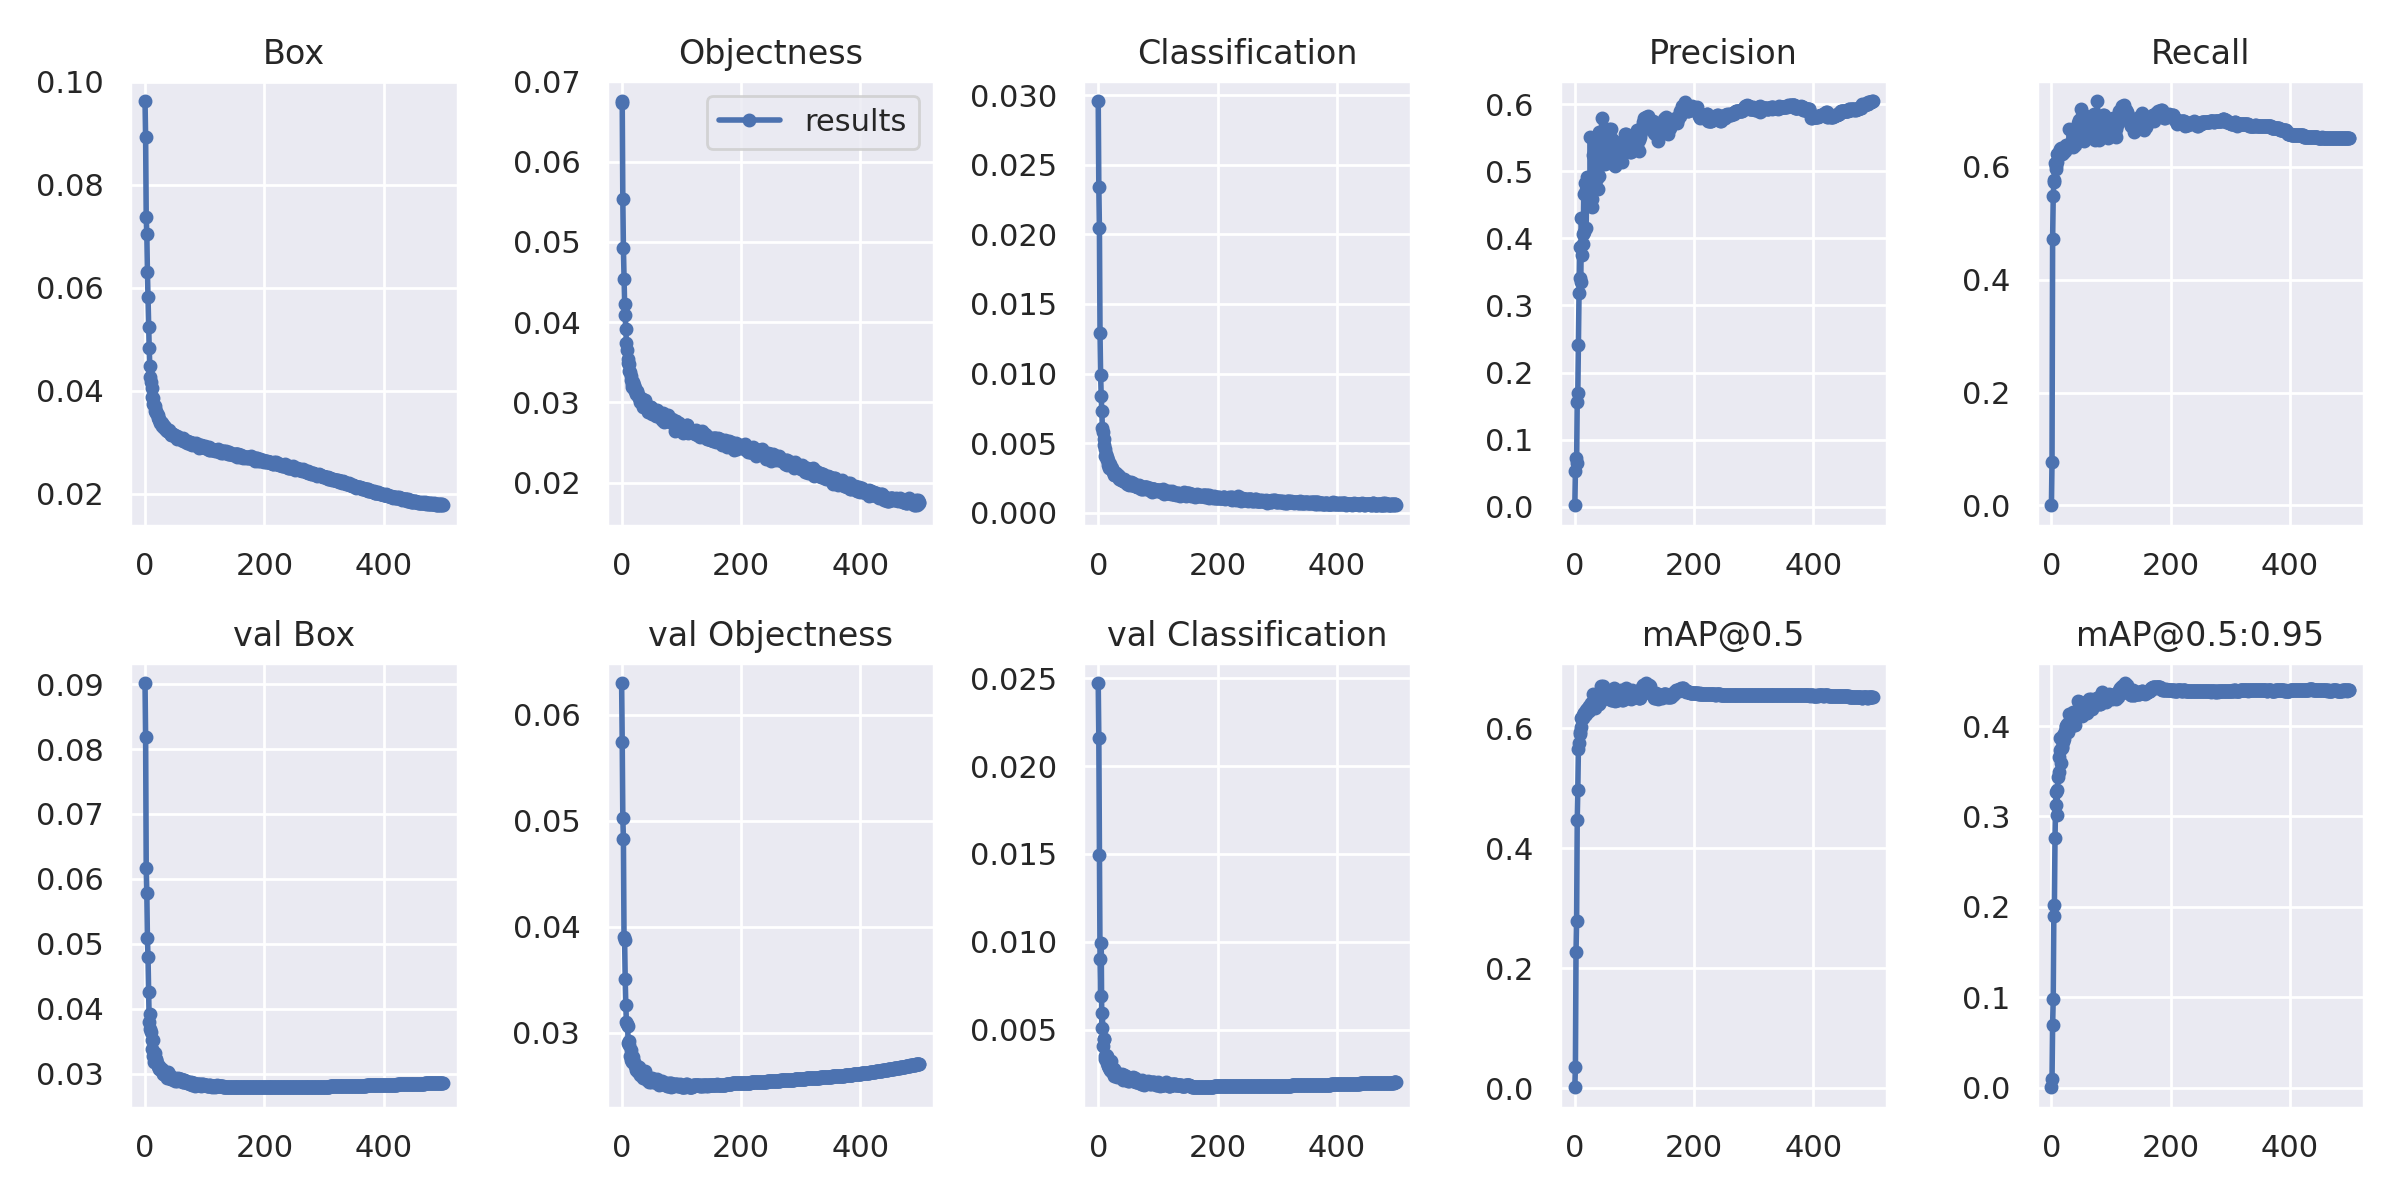

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
import os

result_path = '/content/yolov5/runs/train/yolov5s_results'
for i in range(10, 1, -1):
    potential_path = result_path + str(i)
    if os.path.isdir(potential_path):
        result_path = potential_path
        break

Image(filename=result_path + '/results.png', width=1000)  # view results.png

In [ ]:
end_time = datetime.datetime.now().strftime("%d %b, %H:%M:%S")
print(start_time)
print(end_time)

21 Jan, 06:49:18
21 Jan, 17:01:15


### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


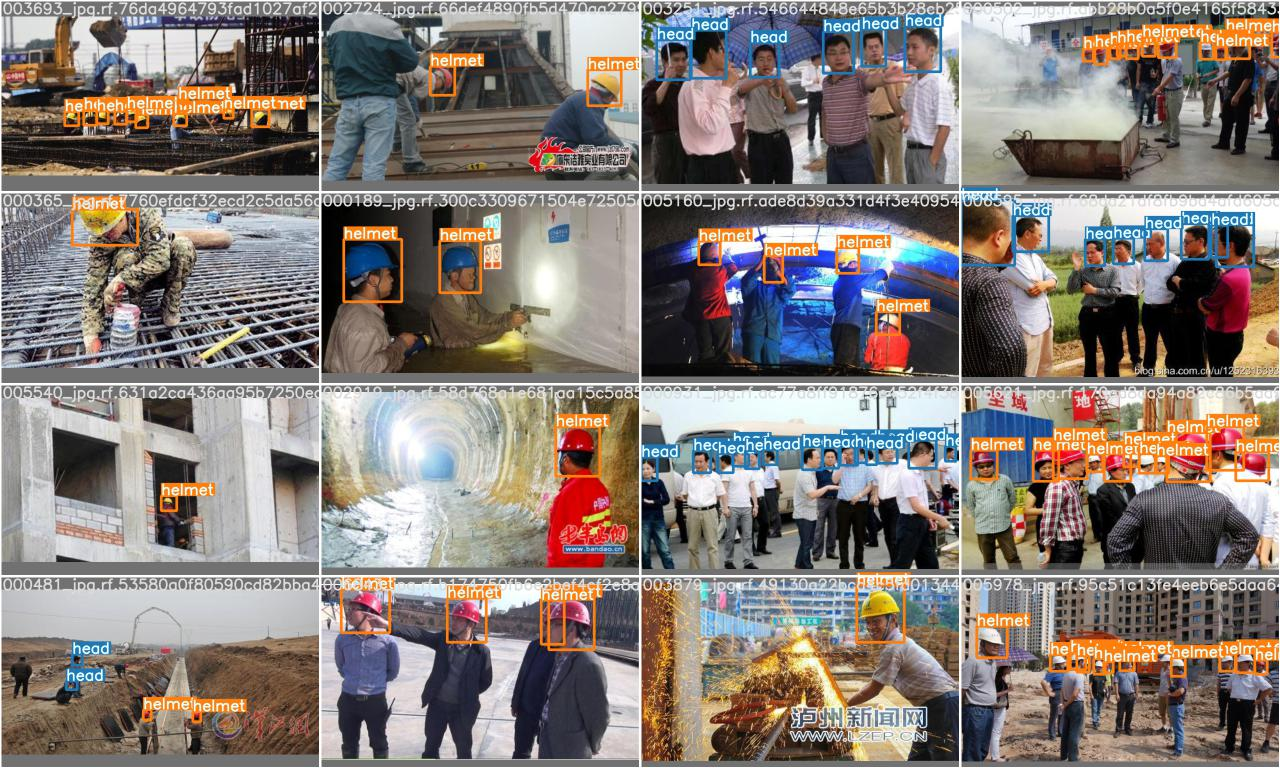

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename=result_path + '/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


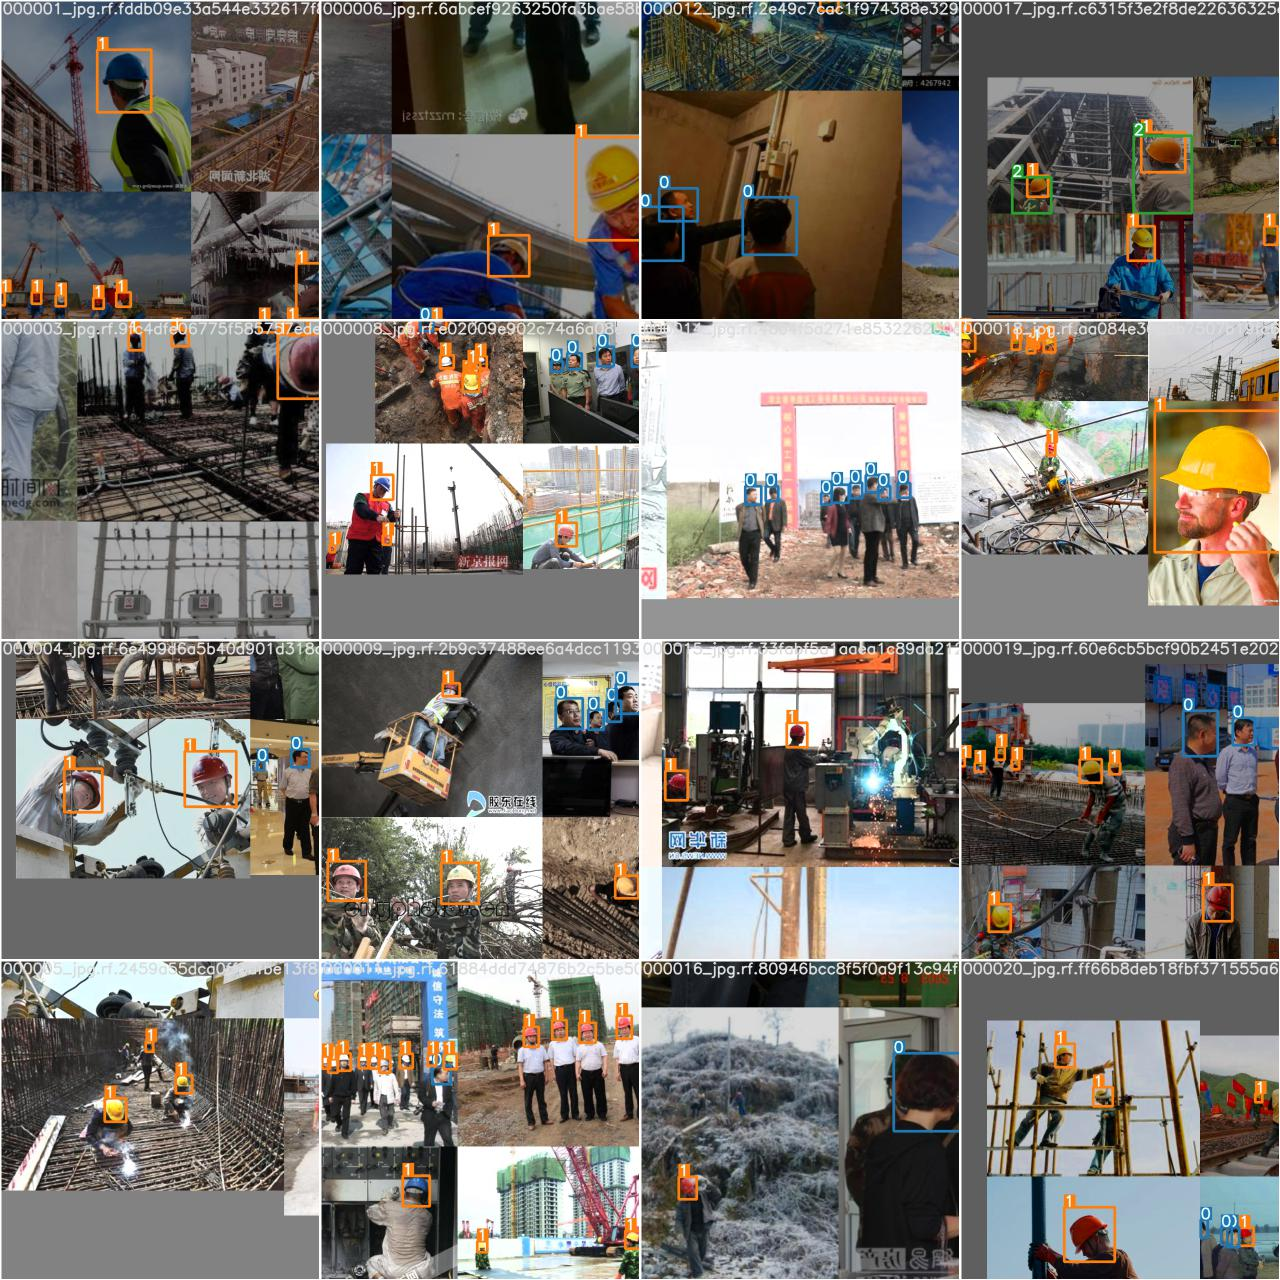

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename=result_path + '/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls {result_path}

confusion_matrix.png                               test_batch0_pred.jpg
events.out.tfevents.1611211853.b8df6cfe13d7.191.0  test_batch1_labels.jpg
hyp.yaml                                           test_batch1_pred.jpg
labels_correlogram.png                             test_batch2_labels.jpg
labels.png                                         test_batch2_pred.jpg
opt.yaml                                           train_batch0.jpg
precision_recall_curve.png                         train_batch1.jpg
results.png                                        train_batch2.jpg
results.txt                                        weights/
test_batch0_labels.jpg


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights {result_path}/weights/best.pt --img 320 --conf 0.4 --source ../test/images   # second test was done with 640

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../test/images', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130MB)

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients
image 1/1055 /content/test/images/000007_jpg.rf.8e98fb789dfc011fb526ce49daf8da31.jpg: 608x640 2 heads, 10 helmets, Done. (0.021s)
image 2/1055 /content/test/images/000024_jpg.rf.f4dbede31bcaa30e4264e464b2d32266.jpg: 448x640 6 heads, 5 helmets, Done. (0.012s)
image 3/1055 /content/test/images/000035_jpg.rf.a3fd81d1d38c11263dc0f6670b50deda.jpg: 480x640 3 helmets, Done. (0.012s)
image 4/1055 /content/test/images/000038_jpg.rf.ee7b22dab5abf8252225253d5b7b50cf.jpg: 384x640 2 helmets, Done. (0.012s)
image 5/1055 /co

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

save_path = '/content/yolov5/runs/detect/exp'
for i in range(10, 1, -1):
    potential_path = save_path + str(i)
    if os.path.isdir(potential_path):
        save_path = potential_path
        break

for imageName in sorted(glob.glob(save_path + '/*.jpg'))[:100]: #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
!python test.py --weights {result_path}/weights/best.pt --data /content/data.yaml --img 320 --task test --verbose

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='/content/data.yaml', device='', exist_ok=False, img_size=320, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=True, weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130MB)

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients
Scanning '../test/labels' for images and labels... 1055 found, 0 missing, 0 empty, 0 corrupted: 100% 1055/1055 [00:00<00:00, 1210.77it/s]
New cache created: ../test/labels.cache
Scanning '../test/labels.cache' for images and labels... 1055 found, 0 missing, 0 empty, 0 corrupted: 100% 1055/1055 [00:00<00:00, 7242210.67it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 33/33 [00:09<00:00,  3.52it/s]
                 all    1.06e+03    4.21e+03         0.5      

In [ ]:
!python test.py --weights {result_path}/weights/best.pt --data /content/data.yaml --img 416 --task test --verbose

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='/content/data.yaml', device='', exist_ok=False, img_size=416, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=True, weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130MB)

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients
Scanning '../test/labels.cache' for images and labels... 1055 found, 0 missing, 0 empty, 0 corrupted: 100% 1055/1055 [00:00<00:00, 6979480.63it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 33/33 [00:10<00:00,  3.07it/s]
                 all    1.06e+03    4.21e+03       0.513       0.635       0.634       0.417
                head    1.06e+03    1.02e+03       0.726       0.933       0.925       0.609
              helmet    1.06e+03    3.09e+03       0.8

In [ ]:
!python test.py --weights {result_path}/weights/best.pt --data /content/data.yaml --img 512 --task test --verbose

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='/content/data.yaml', device='', exist_ok=False, img_size=512, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=True, weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130MB)

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients
Scanning '../test/labels.cache' for images and labels... 1055 found, 0 missing, 0 empty, 0 corrupted: 100% 1055/1055 [00:00<00:00, 8975640.41it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 33/33 [00:10<00:00,  3.06it/s]
                 all    1.06e+03    4.21e+03       0.538       0.644       0.645       0.431
                head    1.06e+03    1.02e+03       0.756       0.941       0.937       0.626
              helmet    1.06e+03    3.09e+03       0.8

In [ ]:
!python test.py --weights {result_path}/weights/best.pt --data /content/data.yaml --img 640 --task test --verbose

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='/content/data.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=True, weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130MB)

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients
Scanning '../test/labels.cache' for images and labels... 1055 found, 0 missing, 0 empty, 0 corrupted: 100% 1055/1055 [00:00<00:00, 8693498.47it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 33/33 [00:12<00:00,  2.67it/s]
                 all    1.06e+03    4.21e+03       0.551       0.652       0.644       0.435
                head    1.06e+03    1.02e+03       0.772       0.946       0.943       0.638
              helmet    1.06e+03    3.09e+03       0.8

In [ ]:
from google.colab import files

!zip -r /content/yolo5.zip {result_path}/*.png {result_path}/*.jpg {result_path}/*.txt {result_path}/weights  runs/detect runs/test/
files.download("/content/yolo5.zip")

  adding: content/yolov5/runs/train/yolov5s_results2/confusion_matrix.png (deflated 31%)
  adding: content/yolov5/runs/train/yolov5s_results2/labels_correlogram.png (deflated 3%)
  adding: content/yolov5/runs/train/yolov5s_results2/labels.png (deflated 2%)
  adding: content/yolov5/runs/train/yolov5s_results2/precision_recall_curve.png (deflated 15%)
  adding: content/yolov5/runs/train/yolov5s_results2/results.png (deflated 10%)
  adding: content/yolov5/runs/train/yolov5s_results2/test_batch0_labels.jpg (deflated 2%)
  adding: content/yolov5/runs/train/yolov5s_results2/test_batch0_pred.jpg (deflated 2%)
  adding: content/yolov5/runs/train/yolov5s_results2/test_batch1_labels.jpg (deflated 3%)
  adding: content/yolov5/runs/train/yolov5s_results2/test_batch1_pred.jpg (deflated 3%)
  adding: content/yolov5/runs/train/yolov5s_results2/test_batch2_labels.jpg (deflated 0%)
  adding: content/yolov5/runs/train/yolov5s_results2/test_batch2_pred.jpg (deflated 0%)
  adding: content/yolov5/runs/trai

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !zip /content/yolo5_640_images.zip runs/detect/exp2/*.jpg  # if extra images needed to be downloaded